In [147]:
from scipy.optimize import leastsq,curve_fit
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
import math as math
from scipy.optimize import curve_fit

Defino funciones y parametros que voy a usar luego. Dist me calcula la distancia euclediana entre dos puntos. Func es el modelo lineal que paso como parametro al LeastSq. 

In [249]:
def dist(p1,p2):
    cant1 = np.abs(p1[0] - p2[0])
    cant2 = np.abs(p1[1] - p2[1])
    dist = np.sqrt((cant1**2) + (cant2**2))
    return dist

def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return distances

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)

def func(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x+b)
    return residual

def exp(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x**b)
    return residual

 

def powerlaw(r, s0, b):  # r0 no es variable aleatoria
    r0 = 300
    return s0*(r/r0)**(-b)

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point
    
    
params = [1, 1]

def evento(poligono,pointsx,pointsy,sigma,evento,pwl,angulo):
    #Genero el punto random.
    random_point = in_hex(poligono)
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
    #Genero la señal 
    #y = 100 - (100/433)*np.asarray(distancias)
    
    """
    Aplico power law

    """

   


    r0 = 300 #metros 
    s0 = 35 #VEM
    b = 2.1
    r = np.asarray(distancias)
    

    y = powerlaw(r,s0,b)
    sigma = np.sqrt(y)
    
    
    #Hago el ajuste
    y_random = np.random.normal(y,sigma,size = len(y))  #signal
    
    #a1 = leastsq(func, params, (np.asarray(distancias), y_random))[0][1]
    #a2 = leastsq(func, params, (np.asarray(distancias), y_random))[0][0]
    #Opcional visualizar el esquematico del evento
    
    parametros_iniciales=[35, 2.1]


    popt, pcov = curve_fit(powerlaw, distancias, y_random, p0=parametros_iniciales)
    
    s0_est = popt[0]
    b_est = popt[1]
    
    
    if evento == True:
        plt.figure(figsize=(8,8))
        polygon = plt.Polygon(poligono,fill=None,edgecolor='r')
        plt.gca().add_patch(polygon)
        plt.xlim(-600,600)
        plt.ylim(-600,600)
        plt.scatter(centro[0],centro[1],s = 100,c ='black')
        plt.scatter(random_point[0],random_point[1],s = 50,c='violet')
        plt.scatter(pointsx,pointsy,s = 100,c = 'black')
        plt.grid(linestyle='--')
        plt.show()
    #Opcional visualizar el ajuste del evento
    
    x =  np.linspace(min(r),max(r),10000)
    y = powerlaw(x,s0_est,b_est)
    
    
    sigma_s0 = np.sqrt(pcov[0,0])
    sigma_b = np.sqrt(pcov[1,1])
    cov_b_s0 = pcov[0,1]
    
    #var_y = (x/r0)**(-2*b_est) * ( (s0_est*np.log(x/r0)*sigma_b)**2 + sigma_s0**2 - 2*s0_est * np.log(x/r0)*cov_b_s0 )
    var_y = (x/r0)**(-2*b_est)*sigma_s0**2 + (s0_est*(x/r0)**(-b_est)*np.log(x/r0)*sigma_b)**2 + 2*(x/r0)**(-b_est)*(-s0_est*(x/r0)**(-b_est))*np.log(x/r0)*cov_b_s0
    
    
    plt.plot(x,np.sqrt(var_y)/y)
    #plt.ylabel('sigma')
    
    
    
    if pwl == True:
        plt.figure(figsize=(7,7))
        
        plt.plot(x,y, label='ajuste pwl')
        plt.errorbar(x,y, yerr = np.sqrt(var_y), alpha=0.2)
        
        plt.plot(distancias,y_random,'o',color = 'orange')
        plt.errorbar(distancias,y_random,yerr =sigma ,ls = 'none',ecolor='black')
        
        plt.title('Ajuste del evento',size = 20)
        plt.grid(linestyle='--')
        
        #plt.plot([],[],' ',label = f'Ordenada = {np.round(a1,3)}')
        #plt.plot([],[],' ',label = f'Pendiente = {np.round(a2,3)}')
        
        plt.ylabel('y(x)',size = 16)
        plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
        plt.xlabel('x',size = 16)
    #Calculo la matriz de covarianza
    #Sum_x = np.sum(distancias)
    #Sum_x2 = np.sum(distancias**2)
    #N = len(distancias)
    #Delta = (N * Sum_x2) - (Sum_x ** 2)
    #cov = np.matrix([[(sigma**2/Delta)*Sum_x2,-(sigma**2/Delta)*Sum_x],[-(sigma**2/Delta)*Sum_x,(sigma**2/Delta)*N]])
    cov = pcov
    coeffcorr = cov[0,1]/(sigma_b*sigma_s0)
    print('Distancias:', distancias)
    print('Estimación de s0:', np.round(s0_est,2),'±',np.round(sigma_s0,2))
    print('Estimación de b_est:', np.round(b_est,2),'±',np.round(sigma_b,2))
    print('Coeff corr', coeffcorr)
    print('sigma_b', sigma_b)
    print('sigma_s0',sigma_s0)
    #return(distancias,y_random,np.round(s0_est,5),np.round(b_est,5),cov)

Defino los puntos del hexagono. Me genero un punto al azar que vive dentro del hexagono. Grafico

Distancias: [463.22289039 250.37645855 133.46465334 508.1249134  699.7311807
 633.73943272 303.1655523 ]
Estimación de s0: 36.05 ± 2.3
Estimación de b_est: 2.0 ± 0.08
Coeff corr -0.9409064716799312
sigma_b 0.08331692808950844
sigma_s0 2.2974308850673086


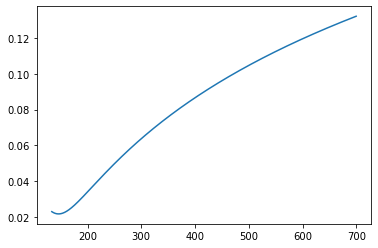

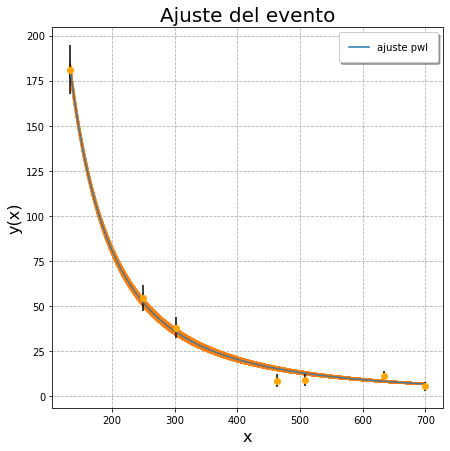

In [250]:
r0 = 300 #metros 
s0 = 35 #VEM
b = 2.1
r = np.asarray(distancias)
sigma = np.sqrt(s0)


evento(poligono,pointsx,pointsy,sigma,False,True,40)

In [ ]:
#buscar x / la var(y) sea minimia